In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [3]:
class KMeans:
    """
    K-Means clustering.

    Attributes:
        n_clusters (int): The number of clusters to form.
        max_iters (int): Maximum number of iterations of the k-means algorithm.
        random_state (int): Determines random number generation for centroid initialization.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=None):
        """
        Initializes the KMeans object.

        Args:
            n_clusters (int, optional): The number of clusters to form. Defaults to 3.
            max_iters (int, optional): Maximum number of iterations. Defaults to 100.
            random_state (int, optional): Random state for initialization. Defaults to None.
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None # Centroid positions will be learned
        self.labels = None # Centroid positions will be learned

    def fit(self, X):
        """
        Computes k-means clustering.

        Args:
            X (ndarray): Training data, shape (n_samples, n_features).
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)

        n_samples, n_features = X.shape

        # Initialize centroids randomly
        self.centroids = X[np.random.choice(n_samples, self.n_clusters, replace=False)]

        # Iterate until convergence or max iterations
        for _ in range(self.max_iters):
            # Assign each sample to the nearest centroid
            self.labels = self._assign_clusters(X)

            # Calculate new centroids
            new_centroids = self._calculate_centroids(X)

            # Check for convergence
            if np.all(self.centroids == new_centroids):
                break

            self.centroids = new_centroids

    def predict(self, X):
        """
        Predict the closest cluster for each sample in X.

        Args:
            X (ndarray): New data to predict, shape (n_samples, n_features).

        Returns:
            ndarray: Index of the cluster each sample belongs to, shape (n_samples,).
        """
        return self._assign_clusters(X)

    def _assign_clusters(self, X):
        """
        Assigns each sample to the nearest centroid.

        Args:
            X (ndarray): Data, shape (n_samples, n_features).

        Returns:
            ndarray: Cluster labels for each sample, shape (n_samples,).
        """
        distances = self._calculate_distances(X, self.centroids)
        return np.argmin(distances, axis=1)

    def _calculate_distances(self, X, centroids):
        """
        Calculates the Euclidean distances between each sample in X and each centroid.

        Args:
            X (ndarray): Data, shape (n_samples, n_features).
            centroids (ndarray): Centroids, shape (n_clusters, n_features).

        Returns:
            ndarray: Distances, shape (n_samples, n_clusters).
        """
        n_samples = X.shape[0]
        n_clusters = centroids.shape[0]
        distances = np.zeros((n_samples, n_clusters))
        for i in range(n_samples):
            for j in range(n_clusters):
                distances[i, j] = np.sqrt(np.sum((X[i] - centroids[j]) ** 2))
        return distances

    def _calculate_centroids(self, X):
        """
        Calculates the new centroids by taking the mean of the samples in each cluster.

        Args:
            X (ndarray): Data, shape (n_samples, n_features).

        Returns:
            ndarray: New centroids, shape (n_clusters, n_features).
        """
        n_clusters = self.n_clusters
        n_features = X.shape[1]
        new_centroids = np.zeros((n_clusters, n_features))
        for cluster_idx in range(n_clusters):
            cluster_points = X[self.labels == cluster_idx]
            if len(cluster_points) > 0:
                new_centroids[cluster_idx] = np.mean(cluster_points, axis=0)
            else:
                # Keep the old centroid if the cluster is empty
                new_centroids[cluster_idx] = self.centroids[cluster_idx]
        return new_centroids

    def fit_predict(self, X):
        """
        Computes cluster centers and predicts cluster index for each sample.
        Convenience method; performs fit() and returns the resulting labels.

        Args:
            X (ndarray): Training data, shape (n_samples, n_features).

        Returns:
            ndarray: Cluster labels for each sample, shape (n_samples,).
        """
        self.fit(X)
        return self.labels
    
    def score(self, X):
        """
        Calculates the Silhouette Coefficient for the given data.

        Args:
            X (ndarray): Input data, shape (n_samples, n_features).

        Returns:
            float: Silhouette Coefficient. Returns None if number of clusters is 1.
        """
        from sklearn.metrics import silhouette_score

        if self.n_clusters <= 1:
            return None  # Silhouette score is not defined for a single cluster

        labels = self.predict(X)
        return silhouette_score(X, labels)

In [5]:
# Load dataset
df = pd.read_csv("cleaned_mlb_2022_full.csv")

# Offensive features to cluster on
features = ['Barrel%', 'EV', 'LA', 'HardHit%', 'K%', 'BB%', 'ISO']

# Drop rows with missing values
df = df.dropna(subset=features)

# Extract features and standardize
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

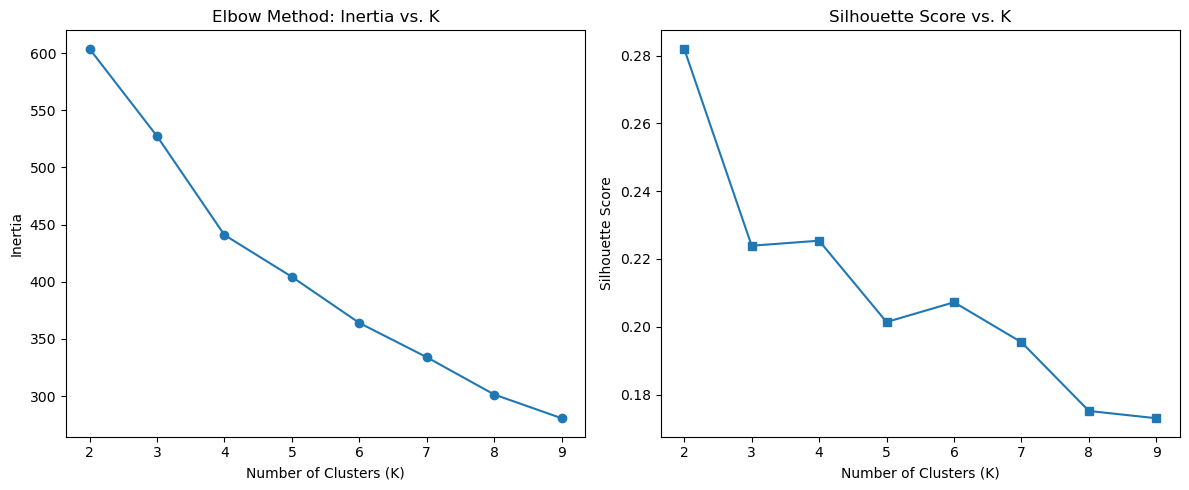

In [7]:
from sklearn.cluster import KMeans as SklearnKMeans  # For evaluation purposes

inertia = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    model = SklearnKMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(k_values, inertia, marker='o')
axs[0].set_title("Elbow Method: Inertia vs. K")
axs[0].set_xlabel("Number of Clusters (K)")
axs[0].set_ylabel("Inertia")

axs[1].plot(k_values, silhouette_scores, marker='s')
axs[1].set_title("Silhouette Score vs. K")
axs[1].set_xlabel("Number of Clusters (K)")
axs[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

The Elbow Method plot (left) displays how within-cluster sum of squares (inertia) decreases with increasing number of clusters (K). The curve starts to flatten around K=4, suggesting that four clusters might be an optimal balance between model complexity and explained variance. Meanwhile, the Silhouette Score plot (right) indicates that K=2 produces the highest average silhouette score, meaning the clusters are well-separated and compact at that value. However, the score remains relatively stable between K=3 and K=4, supporting K=4 as a valid compromise between cohesion and interpretability for this analysis. These plots help guide the selection of K by offering both geometric and statistical perspectives.

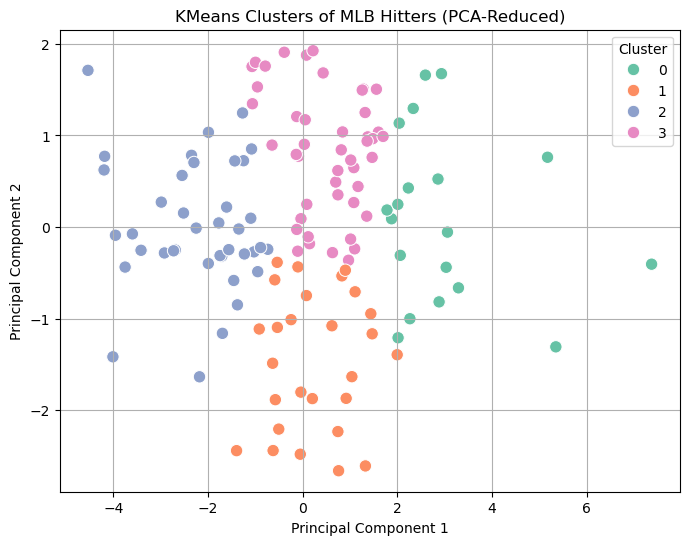

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df['Cluster'] = labels

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=80)
plt.title("KMeans Clusters of MLB Hitters (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


The PCA scatterplot visualizes the four clusters identified by KMeans on a 2D plane reduced from high-dimensional offensive data. Each color represents a different cluster, and the separation suggests that KMeans was able to capture meaningful differences in offensive profiles. Notably, the clusters appear relatively well-dispersed and balanced, with distinct directional tendencies in PCA space. This visualization supports the interpretability of the clustering outcome and allows for exploratory insight into the underlying patterns in the hitter data. It also confirms that reducing the dimensions using PCA did not obscure the separability of the clusters.

Taken together, the evaluation plots and PCA visualization suggest that four clusters effectively capture distinct offensive profiles among MLB hitters. While the silhouette score technically favors K=2, the combination of interpretability and performance around K=4 justifies its selection. The PCA plot confirms that KMeans identified fairly distinct player types based on their offensive features. This clustering approach offers a foundation for segmenting players into tactical or developmental categories, which could help teams tailor coaching strategies or optimize roster construction. Future steps could involve analyzing the cluster centroids or feature distributions to better characterize what defines each offensive type.